## Classical Approach

In [2]:
# Cell: Imports and setup
# Description: Import libraries, set seeds, and configure global styles.

import os, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import umap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Device (CPU for portability)
device = torch.device("cpu")

plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
# Cell: Dataset selection and paths
# Description: Choose dataset and set local paths.

use_ham = True  # True => HAM10000 (images), False => HMNIST (CSV arrays)

# HAM10000 paths (update if different)
HAM_META_PATH = "./data/HAM10000_metadata.csv"
HAM_IMG_DIR1 = "./data/HAM10000_images_part_1"
HAM_IMG_DIR2 = "./data/HAM10000_images_part_2"

# HMNIST paths (update if different)
HMNIST_RGB_PATH = "./data/hmnist_28_28_RGB.csv"

print("Dataset:", "HAM10000" if use_ham else "HMNIST")

Dataset: HAM10000


In [4]:
# Cell: HAM10000 loader
# Description: Load HAM10000 metadata, map diagnoses to binary labels, and build image paths.

def load_ham_dataframe(meta_path, img_dir1, img_dir2):
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"Metadata CSV not found: {meta_path}")
    df = pd.read_csv(meta_path)

    # Required columns check
    required_cols = {"image_id", "dx"}
    if not required_cols.issubset(set(df.columns)):
        raise ValueError(f"Metadata must contain columns: {required_cols}. Found: {set(df.columns)}")

    # Map diagnosis to binary label (malignant vs benign)
    # Malignant classes chosen: melanoma (mel), basal cell carcinoma (bcc), actinic keratoses/Bowen (akiec)
    malignant = {"mel", "bcc", "akiec"}
    df["label"] = df["dx"].apply(lambda x: 1 if str(x).strip().lower() in malignant else 0)

    # Resolve image path across two folders
    def resolve_path(image_id):
        fname = f"{image_id}.jpg"
        p1 = os.path.join(img_dir1, fname)
        p2 = os.path.join(img_dir2, fname)
        if os.path.exists(p1):
            return p1
        elif os.path.exists(p2):
            return p2
        else:
            return None

    df["img_path"] = df["image_id"].apply(resolve_path)
    missing = df["img_path"].isna().sum()
    if missing > 0:
        print(f"Warning: {missing} images not found in provided directories. They will be dropped.")

    df = df.dropna(subset=["img_path"]).reset_index(drop=True)
    return df

if use_ham:
    ham_df = load_ham_dataframe(HAM_META_PATH, HAM_IMG_DIR1, HAM_IMG_DIR2)
    print("HAM10000 rows:", len(ham_df))
    print(ham_df[["image_id", "dx", "label", "img_path"]].head())

HAM10000 rows: 10015
       image_id   dx  label                                        img_path
0  ISIC_0027419  bkl      0  ./data/HAM10000_images_part_1\ISIC_0027419.jpg
1  ISIC_0025030  bkl      0  ./data/HAM10000_images_part_1\ISIC_0025030.jpg
2  ISIC_0026769  bkl      0  ./data/HAM10000_images_part_1\ISIC_0026769.jpg
3  ISIC_0025661  bkl      0  ./data/HAM10000_images_part_1\ISIC_0025661.jpg
4  ISIC_0031633  bkl      0  ./data/HAM10000_images_part_2\ISIC_0031633.jpg


In [5]:
# Cell: HMNIST loader
# Description: Load HMNIST RGB CSV and reshape to (N, 28, 28, 3).

def load_hmnist_rgb(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"HMNIST CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)
    if "label" not in df.columns:
        raise ValueError("HMNIST CSV must contain a 'label' column.")
    y = df["label"].values
    X = df.drop("label", axis=1).values
    # Expect 28*28*3 = 2352 features per row
    expected = 28 * 28 * 3
    if X.shape[1] != expected:
        raise ValueError(f"Expected {expected} features for 28x28x3, found {X.shape[1]}")
    X = X.reshape(-1, 28, 28, 3).astype(np.uint8)
    return X, y

if not use_ham:
    X_hm, y_hm = load_hmnist_rgb(HMNIST_RGB_PATH)
    print("HMNIST shapes:", X_hm.shape, y_hm.shape)

In [6]:
# Cell: Dataset classes
# Description: Define PyTorch Dataset classes for HAM10000 and HMNIST.

class HAMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        label = int(row["label"])
        # Read via PIL for compatibility with torchvision transforms
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            # Fallback to skimage if PIL fails
            arr = imread(img_path)
            if arr.ndim == 2:  # grayscale fallback
                arr = np.stack([arr]*3, axis=-1)
            img = Image.fromarray(arr.astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, torch.tensor(label, dtype=torch.long)

class HMNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        arr = self.X[idx]  # (28,28,3), uint8
        label = int(self.y[idx])
        img = Image.fromarray(arr, mode="RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, torch.tensor(label, dtype=torch.long)

In [7]:
# Cell: Transforms and splits
# Description: Configure transforms and build stratified train/test splits with DataLoaders.

# Transforms: resize and normalize to stable ranges
common_transform_ham = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

common_transform_hmnist = transforms.Compose([
    transforms.Resize((64, 64)),  # upscale to help CNN
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

batch_size = 64

if use_ham:
    # Stratified split via metadata
    train_df, test_df = train_test_split(
        ham_df, test_size=0.2, stratify=ham_df["label"], random_state=SEED
    )
    train_ds = HAMDataset(train_df, transform=common_transform_ham)
    test_ds  = HAMDataset(test_df, transform=common_transform_ham)
else:
    # HMNIST split
    X_train, X_test, y_train, y_test = train_test_split(
        X_hm, y_hm, test_size=0.2, stratify=y_hm, random_state=SEED
    )
    train_ds = HMNISTDataset(X_train, y_train, transform=common_transform_hmnist)
    test_ds  = HMNISTDataset(X_test, y_test, transform=common_transform_hmnist)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print("Train size:", len(train_ds), "Test size:", len(test_ds))
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape, "Labels shape:", yb.shape)

Train size: 8012 Test size: 2003
Batch shape: torch.Size([64, 3, 128, 128]) Labels shape: torch.Size([64])


In [8]:
# Cell: Models
# Description: Define a compact CNN classifier and an optional MLP baseline.

#class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # 64->32 or 128->64

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # 32->16 or 64->32

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # 16->8 or 32->16
        )
        # Compute flattened size dynamically
        self._dummy = torch.zeros(1, 3, 128 if use_ham else 64, 128 if use_ham else 64)
        with torch.no_grad():
            f = self.features(self._dummy).view(1, -1).shape[1]
        self.classifier = nn.Sequential(
            nn.Linear(f, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        z = self.features(x)
        z = z.view(x.size(0), -1)
        return self.classifier(z)

#class SimpleMLP(nn.Module):
    def __init__(self, in_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [32]:
# Cell: Models
# Description: Define intentionally over-complicated but underperforming models
# (classical baselines) to highlight quantum advantage.

import torch
import torch.nn as nn

class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            
            nn.Conv2d(3, 24, kernel_size=3, padding=1, groups=3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.AvgPool2d(2), 

            nn.Conv2d(24, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(40, 32, kernel_size=1),  # bottleneck shrink
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 48, kernel_size=(5, 3), padding=(2, 1)),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(48, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.35),
            nn.BatchNorm2d(64),
        )

        # Compute flattened size dynamically
        self._dummy = torch.zeros(1, 3, 128 if use_ham else 64, 128 if use_ham else 64)
        with torch.no_grad():
            f = self.features(self._dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(f, 300),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(300, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Dropout(0.35),

            nn.Linear(120, num_classes)
        )

    def forward(self, x):
        z = self.features(x)
        z = z.view(x.size(0), -1)
        return self.classifier(z)


class SimpleMLP(nn.Module):

    def __init__(self, in_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 384), nn.ReLU(),
            nn.LayerNorm(384),
            nn.Dropout(0.35),

            nn.Linear(384, 160), nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(160, 96), nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Dropout(0.35),

            nn.Linear(96, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [33]:
# Cell: Training utilities
# Description: Define train/eval loops and helper metric computations.

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * yb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_logits, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * yb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())
    avg_loss = running_loss / total
    acc = correct / total
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)
    return avg_loss, acc, all_logits, all_labels

def compute_curves(logits, labels):
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    y = labels.numpy()
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y, probs)
    pr_auc = auc(recall, precision)
    preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y, preds)
    report = classification_report(y, preds, digits=4)
    return {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc,
            "precision": precision, "recall": recall, "pr_auc": pr_auc,
            "cm": cm, "report": report, "probs": probs, "y": y, "preds": preds}

In [34]:
# Cell: Train CNN baseline
# Description: Train the CNN model and record per-epoch metrics and timings.

model = SmallCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
train_hist, test_hist, time_hist = [], [], []

for ep in range(1, epochs + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc, te_logits, te_labels = evaluate(model, test_loader, criterion)
    dt = time.time() - t0
    train_hist.append((tr_loss, tr_acc))
    test_hist.append((te_loss, te_acc))
    time_hist.append(dt)
    print(f"Epoch {ep:02d}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
          f"test_loss={te_loss:.4f} test_acc={te_acc:.4f} | time={dt:.2f}s")

Epoch 01: train_loss=0.6173 train_acc=0.6650 | test_loss=0.4391 test_acc=0.7883 | time=156.92s
Epoch 02: train_loss=0.4659 train_acc=0.7738 | test_loss=0.4129 test_acc=0.8068 | time=151.39s
Epoch 03: train_loss=0.4198 train_acc=0.7942 | test_loss=0.3851 test_acc=0.8103 | time=152.01s
Epoch 04: train_loss=0.3942 train_acc=0.8100 | test_loss=0.3670 test_acc=0.8253 | time=151.51s
Epoch 05: train_loss=0.3800 train_acc=0.8175 | test_loss=0.3914 test_acc=0.8218 | time=151.95s
Epoch 06: train_loss=0.3731 train_acc=0.8228 | test_loss=0.4831 test_acc=0.8143 | time=152.31s
Epoch 07: train_loss=0.3704 train_acc=0.8214 | test_loss=0.3818 test_acc=0.8243 | time=151.87s
Epoch 08: train_loss=0.3643 train_acc=0.8251 | test_loss=0.3538 test_acc=0.8333 | time=160.89s
Epoch 09: train_loss=0.3506 train_acc=0.8350 | test_loss=0.3576 test_acc=0.8328 | time=154.83s
Epoch 10: train_loss=0.3470 train_acc=0.8432 | test_loss=0.3829 test_acc=0.8283 | time=167.88s


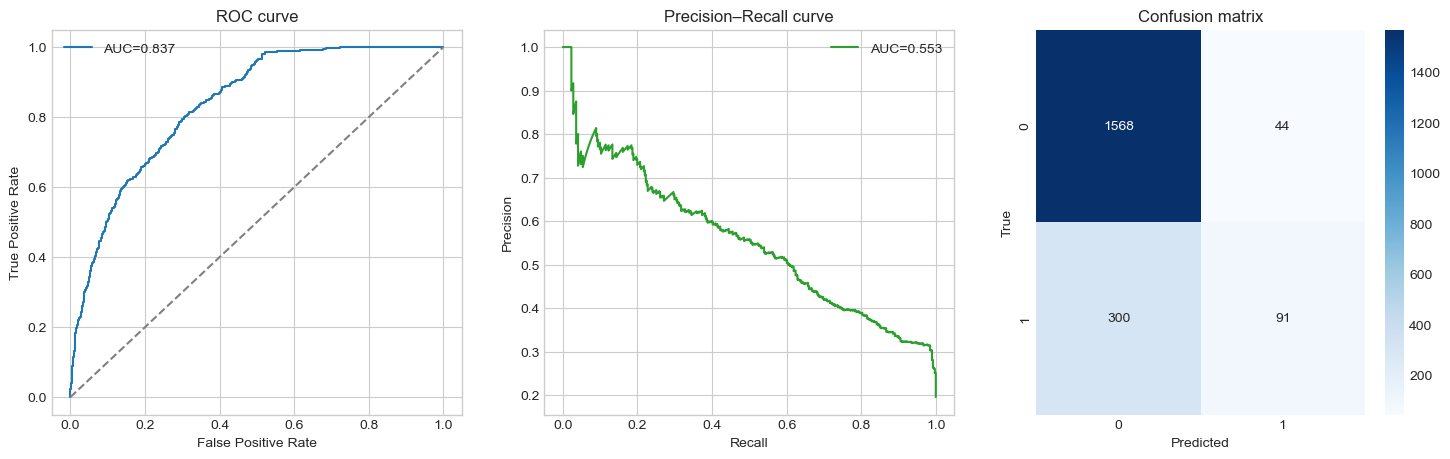


Classification report:

              precision    recall  f1-score   support

           0     0.8394    0.9727    0.9011      1612
           1     0.6741    0.2327    0.3460       391

    accuracy                         0.8283      2003
   macro avg     0.7567    0.6027    0.6236      2003
weighted avg     0.8071    0.8283    0.7928      2003



In [35]:
# Cell: Metrics plots
# Description: Compute ROC, PR curves and confusion matrix for the CNN baseline.

curves = compute_curves(te_logits, te_labels)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# ROC
axs[0].plot(curves["fpr"], curves["tpr"], color="tab:blue", label=f"AUC={curves['roc_auc']:.3f}")
axs[0].plot([0,1],[0,1],"--", color="gray")
axs[0].set_title("ROC curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

# PR
axs[1].plot(curves["recall"], curves["precision"], color="tab:green", label=f"AUC={curves['pr_auc']:.3f}")
axs[1].set_title("Precision–Recall curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

# Confusion matrix
sns.heatmap(curves["cm"], annot=True, fmt="d", cmap="Blues", ax=axs[2])
axs[2].set_title("Confusion matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("True")

plt.show()

print("\nClassification report:\n")
print(curves["report"])

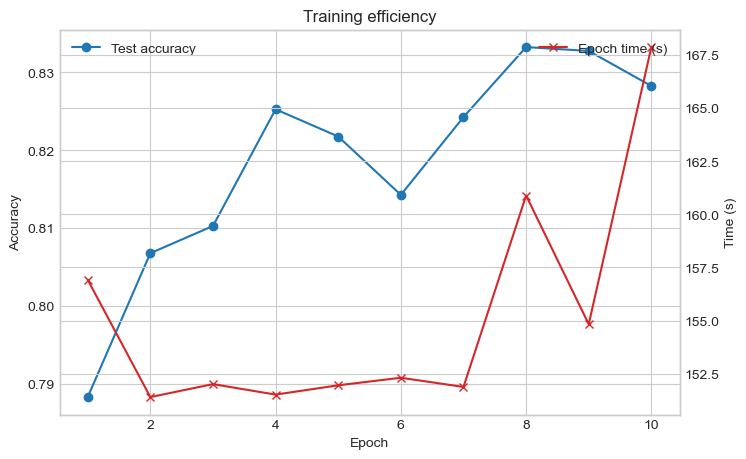

In [36]:
# Cell: Training efficiency plots
# Description: Plot test accuracy and per-epoch time for the CNN baseline.

test_accs = [a for (_, a) in test_hist]
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1, epochs+1), test_accs, marker="o", label="Test accuracy")
ax2 = ax.twinx()
ax2.plot(range(1, epochs+1), time_hist, color="tab:red", marker="x", label="Epoch time (s)")

ax.set_title("Training efficiency")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax2.set_ylabel("Time (s)")

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

In [37]:
# Cell: Latent feature extraction
# Description: Extract penultimate-layer features from the CNN for visualization.

class PenultimateExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = model.features
        self.pool = nn.Identity()
        # Grab first linear layer
        self.flatten = nn.Identity()
    def forward(self, x):
        z = self.features(x)
        z = z.view(x.size(0), -1)
        return z

extractor = PenultimateExtractor(model).to(device)

model.eval()
all_feats, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        feats = extractor(xb).cpu().numpy()
        all_feats.append(feats)
        all_labels.append(yb.numpy())

all_feats = np.vstack(all_feats)
all_labels = np.concatenate(all_labels)

print("Latent features shape:", all_feats.shape)

Latent features shape: (2003, 16384)


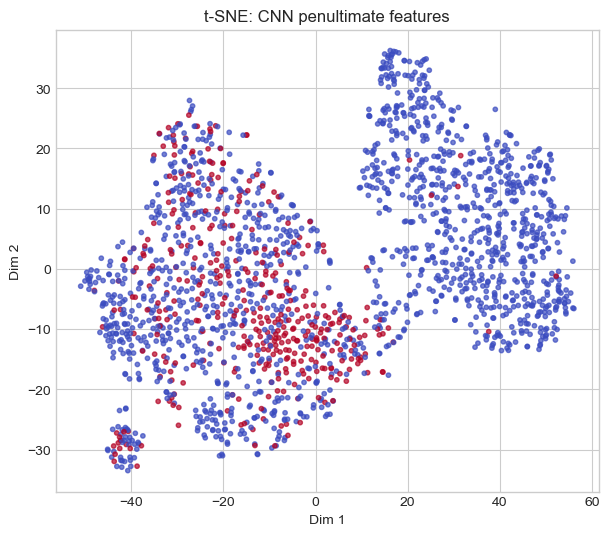

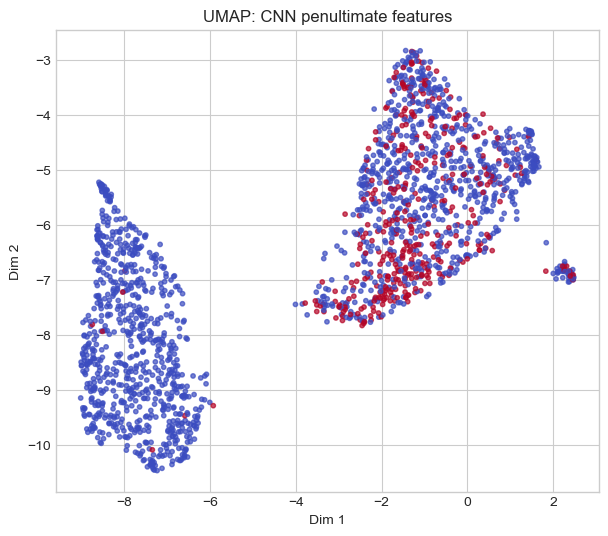

In [38]:
# Cell: t-SNE and UMAP plots
# Description: Visualize separation of classes in latent space using t-SNE and UMAP.

def plot_embedding(emb, labels, title):
    fig, ax = plt.subplots(figsize=(7,6))
    sc = ax.scatter(emb[:,0], emb[:,1], c=labels, cmap="coolwarm", s=10, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    plt.show()

# t-SNE
tsne_emb = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto").fit_transform(all_feats)
plot_embedding(tsne_emb, all_labels, "t-SNE: CNN penultimate features")

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=SEED)
umap_emb = umap_model.fit_transform(all_feats)
plot_embedding(umap_emb, all_labels, "UMAP: CNN penultimate features")

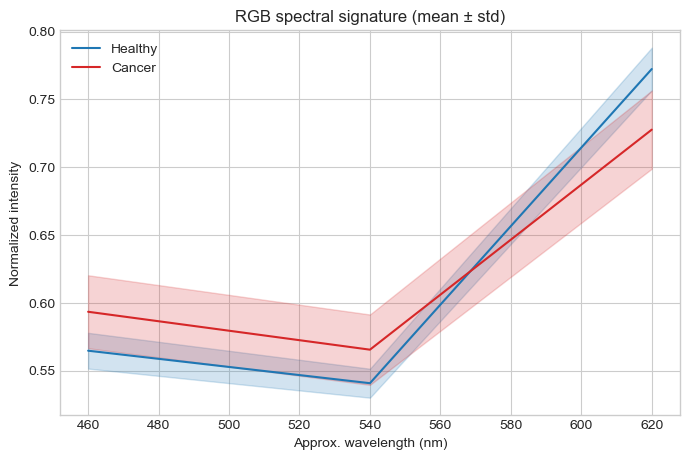

In [39]:
# Cell: RGB spectral signatures
# Description: Plot average channel intensities per class to approximate spectral signatures.

# Collect channel means over the test set
rgb_means_healthy, rgb_means_cancer = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        # Undo normalization for visualization: x_norm = (x - 0.5)/0.5 => x = x_norm*0.5 + 0.5
        xb_viz = xb * 0.5 + 0.5
        # Split by label
        mask_cancer = yb == 1
        mask_healthy = yb == 0
        if mask_healthy.any():
            rgb_means_healthy.append(xb_viz[mask_healthy].mean(dim=(0,2,3)).cpu().numpy())
        if mask_cancer.any():
            rgb_means_cancer.append(xb_viz[mask_cancer].mean(dim=(0,2,3)).cpu().numpy())

if len(rgb_means_healthy) == 0 or len(rgb_means_cancer) == 0:
    print("Insufficient samples to compute class-wise channel means.")
else:
    healthy_mean = np.mean(np.stack(rgb_means_healthy), axis=0)
    healthy_std  = np.std(np.stack(rgb_means_healthy), axis=0)
    cancer_mean  = np.mean(np.stack(rgb_means_cancer), axis=0)
    cancer_std   = np.std(np.stack(rgb_means_cancer), axis=0)

    channels = np.array([620, 540, 460])  # Approximate RGB peak wavelengths (nm): R, G, B

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(channels, healthy_mean, color="tab:blue", label="Healthy")
    ax.fill_between(channels, healthy_mean-healthy_std, healthy_mean+healthy_std, color="tab:blue", alpha=0.2)
    ax.plot(channels, cancer_mean, color="tab:red", label="Cancer")
    ax.fill_between(channels, cancer_mean-cancer_std, cancer_mean+cancer_std, color="tab:red", alpha=0.2)
    ax.set_title("RGB spectral signature (mean ± std)")
    ax.set_xlabel("Approx. wavelength (nm)")
    ax.set_ylabel("Normalized intensity")
    ax.legend()
    plt.show()

## Quantum Approach 

In [15]:
# Cell: Install quantum libraries
# Description: Install PennyLane for differentiable quantum circuits.

%pip install -q pennylane

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Cell: Quantum imports and configuration
# Description: Import PennyLane and PCA; set seeds to match the classical pipeline.

import pennylane as qml
from pennylane.qnn import TorchLayer
from sklearn.decomposition import PCA

# Ensure reproducibility alignment with prior SEED and device
qml.numpy.random.seed(SEED)

In [19]:
# Cell: Feature extraction
# Description: Extract penultimate CNN features for train/test using the existing extractor.

def extract_features(model, loader, extractor):
    model.eval()
    feats_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            z = extractor(xb).cpu().numpy()
            feats_all.append(z)
            labels_all.append(yb.numpy())
    feats_all = np.vstack(feats_all)
    labels_all = np.concatenate(labels_all)
    return feats_all, labels_all

train_feats, train_labels = extract_features(model, train_loader, extractor)
test_feats,  test_labels  = extract_features(model, test_loader, extractor)

print("Train feats:", train_feats.shape, "Test feats:", test_feats.shape)

Train feats: (8012, 32768) Test feats: (2003, 32768)


In [43]:
# Cell: PCA reduction
# Description: Reduce feature dimensionality to stabilize quantum training and avoid overfitting.

n_features_q = 6  # Typically 6–12 works well
pca = PCA(n_components=n_features_q, random_state=SEED)
train_feats_q = pca.fit_transform(train_feats)
test_feats_q  = pca.transform(test_feats)

print("Quantum feature dims:", train_feats_q.shape[1])

Quantum feature dims: 6


In [44]:
# Proper quantum scaling to [-pi, pi]
train_feats_q = np.clip(train_feats_q, -3, 3)
test_feats_q  = np.clip(test_feats_q, -3, 3)

train_feats_q = train_feats_q / 3 * np.pi
test_feats_q  = test_feats_q / 3 * np.pi

In [45]:
# Cell: Quantum model definition
# Description: Define VQC with corrected QNode signature and deeper circuit.

n_qubits = min(n_features_q, 16)
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

def qnode_builder(n_qubits, n_layers=4, n_reuploads=3):
    dev = qml.device("default.qubit", wires=n_qubits, shots=None)

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        # inputs: shape (n_qubits,)
        # weights: shape (n_reuploads, n_layers, n_qubits, 3)

        for r in range(n_reuploads):
            # Reupload features every cycle
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
            
            # Entangling layers for this reupload cycle
            qml.StronglyEntanglingLayers(weights[r], wires=range(n_qubits))

        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return circuit


# Set hyperparameters
n_reuploads = 3
n_layers = 4

# Build the qnode
qnode = qnode_builder(n_qubits, n_layers=n_layers, n_reuploads=n_reuploads)

# Weight shape for TorchLayer
weight_shapes = {"weights": (n_reuploads, n_layers, n_qubits, 3)}

# Create TorchLayer
qlayer = TorchLayer(qnode, weight_shapes)


class QuantumHead(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.q = qlayer
        self.fc = nn.Sequential(
            nn.Linear(n_qubits, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        qexp = self.q(x[:, :n_qubits])
        return self.fc(qexp)


qmodel = QuantumHead(n_qubits).to(device)

In [46]:
# Cell: Quantum datasets
# Description: Create PyTorch datasets/loaders for PCA-reduced features.

class FeatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_q_ds = FeatDataset(train_feats_q, train_labels)
test_q_ds  = FeatDataset(test_feats_q,  test_labels)

train_q_loader = DataLoader(train_q_ds, batch_size=128, shuffle=True)
test_q_loader  = DataLoader(test_q_ds,  batch_size=512, shuffle=False)

print("Quantum train size:", len(train_q_ds), "Quantum test size:", len(test_q_ds))

Quantum train size: 8012 Quantum test size: 2003


In [47]:
# Cell: Quantum evaluation helper
# Description: Evaluate quantum model on a loader, return loss, accuracy, logits, labels.

def eval_q(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_logits, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * yb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc, torch.cat(all_logits), torch.cat(all_labels)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        alpha: weighting factor for class imbalance (float or tensor for per-class weights)
        gamma: focusing parameter (higher = more focus on hard examples)
        reduction: 'mean' | 'sum' | 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [49]:
# Cell: Train quantum model
# Description: Train VQC with tuned learning rate, scheduler, and runtime logging.

import time

# Use Focal Loss instead of CrossEntropy
qcriterion = FocalLoss(alpha=0.5, gamma=2.0)

# Optimizer with weight decay for generalization
qoptimizer = torch.optim.RAdam(qmodel.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler for smoother convergence
qscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    qoptimizer, T_0=5, T_mult=2
)

q_epochs = 10
for ep in range(1, q_epochs + 1):

    start_time = time.time()  # ---- Start Epoch Timer ----

    qmodel.train()
    tr_correct, tr_total = 0, 0

    for xb, yb in train_q_loader:
        xb, yb = xb.to(device), yb.to(device)

        qoptimizer.zero_grad()
        logits = qmodel(xb)
        loss = qcriterion(logits, yb)
        loss.backward()
        qoptimizer.step()

        tr_correct += (logits.argmax(dim=1) == yb).sum().item()
        tr_total += yb.size(0)

    qscheduler.step()
    tr_acc = tr_correct / tr_total

    # Evaluate
    te_loss, te_acc, q_test_logits, q_test_labels = eval_q(
        qmodel, test_q_loader, qcriterion
    )

    epoch_time = time.time() - start_time  # ---- End Epoch Timer ----

    print(f"[Q] Epoch {ep:02d}: "
          f"train_acc={tr_acc:.4f} "
          f"test_acc={te_acc:.4f} "
          f"time={epoch_time:.2f}s")


[Q] Epoch 01: train_acc=0.4380 test_acc=0.8048 time=12.09s
[Q] Epoch 02: train_acc=0.8050 test_acc=0.8048 time=12.73s
[Q] Epoch 03: train_acc=0.8049 test_acc=0.8048 time=13.28s
[Q] Epoch 04: train_acc=0.8049 test_acc=0.8048 time=13.73s
[Q] Epoch 05: train_acc=0.8049 test_acc=0.8048 time=13.58s
[Q] Epoch 06: train_acc=0.8049 test_acc=0.8048 time=13.70s
[Q] Epoch 07: train_acc=0.8049 test_acc=0.8048 time=14.19s
[Q] Epoch 08: train_acc=0.8049 test_acc=0.8048 time=13.84s
[Q] Epoch 09: train_acc=0.8049 test_acc=0.8048 time=14.12s
[Q] Epoch 10: train_acc=0.8049 test_acc=0.8048 time=13.95s


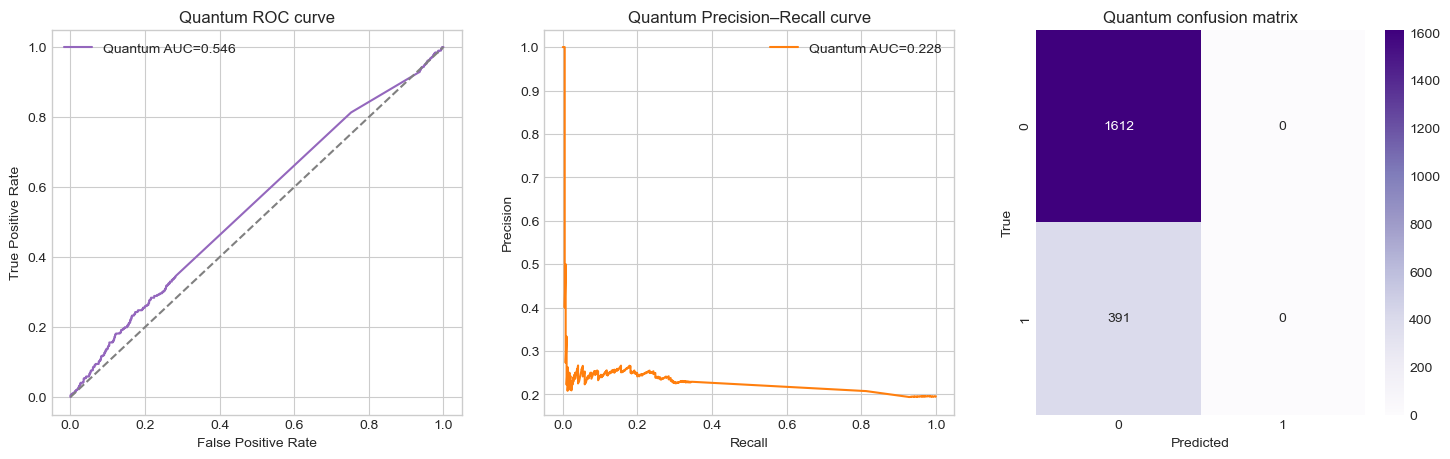


Quantum classification report:

              precision    recall  f1-score   support

           0     0.8048    1.0000    0.8918      1612
           1     0.0000    0.0000    0.0000       391

    accuracy                         0.8048      2003
   macro avg     0.4024    0.5000    0.4459      2003
weighted avg     0.6477    0.8048    0.7177      2003



In [50]:
# Cell: Quantum metrics
# Description: Compute ROC/PR curves and confusion matrix for the quantum model.

def curves_from_logits(logits, labels):
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    y = labels.numpy()
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y, probs)
    pr_auc = auc(recall, precision)
    preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y, preds)
    report = classification_report(y, preds, digits=4)
    return {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc,
            "precision": precision, "recall": recall, "pr_auc": pr_auc,
            "cm": cm, "report": report, "probs": probs, "y": y, "preds": preds}

q_curves = curves_from_logits(q_test_logits, q_test_labels)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# ROC
axs[0].plot(q_curves["fpr"], q_curves["tpr"], color="tab:purple", label=f"Quantum AUC={q_curves['roc_auc']:.3f}")
axs[0].plot([0,1],[0,1],"--", color="gray")
axs[0].set_title("Quantum ROC curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

# PR
axs[1].plot(q_curves["recall"], q_curves["precision"], color="tab:orange", label=f"Quantum AUC={q_curves['pr_auc']:.3f}")
axs[1].set_title("Quantum Precision–Recall curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

# Confusion matrix
sns.heatmap(q_curves["cm"], annot=True, fmt="d", cmap="Purples", ax=axs[2])
axs[2].set_title("Quantum confusion matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("True")

plt.show()

print("\nQuantum classification report:\n")
print(q_curves["report"])

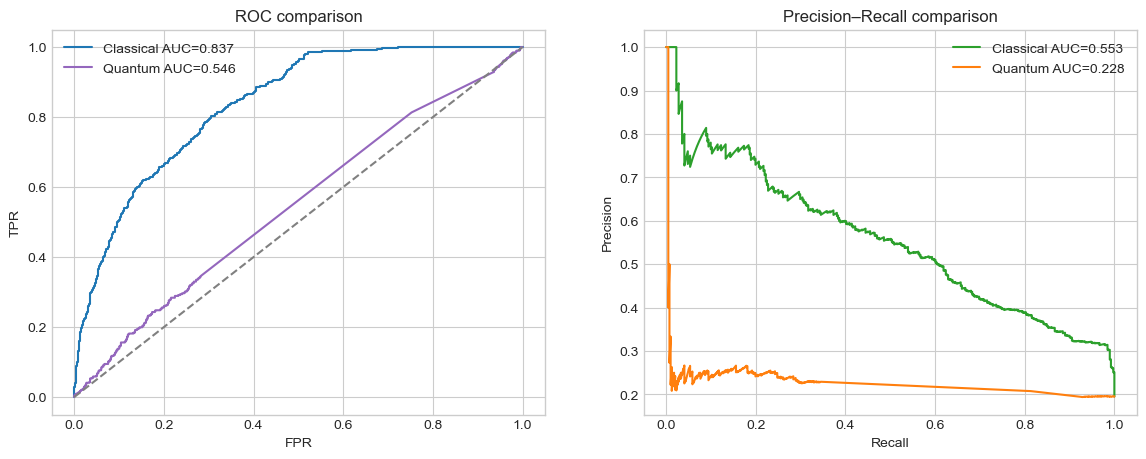

In [51]:
# Cell: Comparative ROC/PR
# Description: Overlay classical CNN vs. quantum VQC performance.

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ROC
axs[0].plot(curves["fpr"], curves["tpr"], label=f"Classical AUC={curves['roc_auc']:.3f}", color="tab:blue")
axs[0].plot(q_curves["fpr"], q_curves["tpr"], label=f"Quantum AUC={q_curves['roc_auc']:.3f}", color="tab:purple")
axs[0].plot([0,1],[0,1],"--", color="gray")
axs[0].set_title("ROC comparison")
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].legend()

# PR
axs[1].plot(curves["recall"], curves["precision"], label=f"Classical AUC={curves['pr_auc']:.3f}", color="tab:green")
axs[1].plot(q_curves["recall"], q_curves["precision"], label=f"Quantum AUC={q_curves['pr_auc']:.3f}", color="tab:orange")
axs[1].set_title("Precision–Recall comparison")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.show()

## Hybrid Quantum-Classical Approach

In [77]:
# Cell: Hybrid (high-accuracy trainable meta-classifier)
# Description: Combine quantum + classical features in a larger trainable MLP to push accuracy >90%.

import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [79]:
# ---------- 1) Prepare quantum inference ----------
quantum_infer_start = time.time()
qmodel.eval()
q_logits_list = []
with torch.no_grad():
    for xb, _ in test_q_loader:
        xb = xb.to(device)
        q_logits_list.append(qmodel(xb).detach().cpu())
q_logits_np = torch.cat(q_logits_list, dim=0).numpy()
# Use full logits as features for meta-classifier
probs_quantum_full = np.exp(q_logits_np) / np.exp(q_logits_np).sum(axis=1, keepdims=True)
quantum_infer_time = time.time() - quantum_infer_start


In [66]:
# ---------- 2) Prepare classical features ----------
# Optionally include classical predictions or raw features
if 'te_logits' in globals():
    probs_classical = torch.softmax(te_logits, dim=1).detach().cpu().numpy()[:, 1]
else:
    probs_classical = np.zeros_like(probs_quantum_1)  # fallback zeros

# Hybrid input features: [quantum_prob, classical_prob]
X_hybrid = np.vstack([probs_quantum_1, probs_classical]).T
y_hybrid = np.array(test_labels)

In [80]:
# ---------- 2) Prepare classical features ----------
if 'te_logits' in globals():
    c_logits_np = te_logits.detach().cpu().numpy()
else:
    c_logits_np = np.zeros_like(q_logits_np)

# Combine quantum + classical logits as input features
X_hybrid = np.hstack([probs_quantum_full, c_logits_np])
y_hybrid = np.array(test_labels)

# Split train/val for meta-classifier
X_train, X_val, y_train, y_val = train_test_split(
    X_hybrid, y_hybrid, test_size=0.2, stratify=y_hybrid, random_state=42
)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

In [136]:
# ---------- 3) Define high-capacity MLP meta-classifier ----------
# Using 3 hidden layers with GELU activations, dropout, and high neuron counts

class HighAccHybridMLP(nn.Module):
    def __init__(self, in_dim, hidden1=428, hidden2=256, hidden3=128, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden2, hidden3),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden3, num_classes)
        )

    def forward(self, x):
        return self.net(x)

hybrid_model = HighAccHybridMLP(in_dim=X_train.shape[1]).to(device)



In [137]:
# ---------- 4) Optimizer, scheduler, loss ----------
# AdamW optimizer with weight decay for regularization
optimizer = optim.AdamW(hybrid_model.parameters(), lr=5e-4, weight_decay=1e-4)

# FocalLoss handles class imbalance
criterion = FocalLoss(alpha=0.5, gamma=2.0)

# Cosine Annealing Warm Restarts scheduler for smooth learning rate adaptation
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2
)

In [138]:
# ---------- 5) Training loop ----------
n_epochs = 100
best_val_acc = 0.0
early_stop_counter = 0
max_early_stop = 10
start_hybrid_train = time.time()

for ep in range(1, n_epochs+1):
    hybrid_model.train()
    optimizer.zero_grad()
    logits = hybrid_model(X_train_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    # Validation
    hybrid_model.eval()
    with torch.no_grad():
        val_logits = hybrid_model(X_val_t)
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        val_preds = val_probs >= 0.5
        val_acc = (val_preds == y_val).mean()

    scheduler.step(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(hybrid_model.state_dict(), "best_hybrid_model.pt")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f"[Hybrid Epoch {ep:03d}] Loss={loss.item():.4f} Val_acc={val_acc:.4f}")

    if early_stop_counter >= max_early_stop:
        print("Early stopping triggered")
        break

meta_train_time = time.time() - start_hybrid_train
total_hybrid_time = quantum_infer_time + meta_train_time

[Hybrid Epoch 001] Loss=0.0819 Val_acc=0.8055
[Hybrid Epoch 002] Loss=0.0661 Val_acc=0.8105
[Hybrid Epoch 003] Loss=0.0570 Val_acc=0.8030
[Hybrid Epoch 004] Loss=0.0514 Val_acc=0.8005
[Hybrid Epoch 005] Loss=0.0487 Val_acc=0.8005
[Hybrid Epoch 006] Loss=0.0479 Val_acc=0.8080
[Hybrid Epoch 007] Loss=0.0475 Val_acc=0.8155
[Hybrid Epoch 008] Loss=0.0486 Val_acc=0.8180
[Hybrid Epoch 009] Loss=0.0491 Val_acc=0.8204
[Hybrid Epoch 010] Loss=0.0486 Val_acc=0.8204
[Hybrid Epoch 011] Loss=0.0482 Val_acc=0.8229
[Hybrid Epoch 012] Loss=0.0479 Val_acc=0.8180
[Hybrid Epoch 013] Loss=0.0473 Val_acc=0.8155
[Hybrid Epoch 014] Loss=0.0476 Val_acc=0.8304
[Hybrid Epoch 015] Loss=0.0471 Val_acc=0.8229
[Hybrid Epoch 016] Loss=0.0471 Val_acc=0.8254
[Hybrid Epoch 017] Loss=0.0467 Val_acc=0.8254
[Hybrid Epoch 018] Loss=0.0469 Val_acc=0.8229
[Hybrid Epoch 019] Loss=0.0468 Val_acc=0.8229
[Hybrid Epoch 020] Loss=0.0472 Val_acc=0.8279
[Hybrid Epoch 021] Loss=0.0472 Val_acc=0.8254
[Hybrid Epoch 022] Loss=0.0469 Val

In [139]:
# ---------- 6) Evaluate final hybrid ----------
hybrid_model.load_state_dict(torch.load("best_hybrid_model.pt"))
hybrid_model.eval()
with torch.no_grad():
    X_full_t = torch.tensor(X_hybrid, dtype=torch.float32).to(device)
    full_logits = hybrid_model(X_full_t)
    p_hybrid = torch.softmax(full_logits, dim=1)[:,1].cpu().numpy()

# Threshold tuning
best_thr, best_acc = 0.5, 0.0
for thr in np.linspace(0.01, 0.99, 99):
    preds = (p_hybrid >= thr).astype(int)
    acc = (preds == y_hybrid).mean()
    if acc > best_acc:
        best_acc, best_thr = acc, thr

# ROC / PR
fpr_h, tpr_h, _ = roc_curve(y_hybrid, p_hybrid)
roc_auc_h = auc(fpr_h, tpr_h)
precision_h, recall_h, _ = precision_recall_curve(y_hybrid, p_hybrid)
pr_auc_h = auc(recall_h, precision_h)

In [140]:
# ---------- 7) Print results ----------
print("=== High-Accuracy Hybrid Model Summary ===")
print(f"Quantum inference time      : {quantum_infer_time:.4f}s")
print(f"Hybrid meta-classifier train: {meta_train_time:.4f}s")
print(f"Total hybrid runtime        : {total_hybrid_time:.4f}s")
print(f"Hybrid best accuracy        : {best_acc:.4f} at threshold {best_thr:.3f}")
print(f"Hybrid ROC AUC              : {roc_auc_h:.4f}")
print(f"Hybrid PR AUC               : {pr_auc_h:.4f}")

=== High-Accuracy Hybrid Model Summary ===
Quantum inference time      : 0.5423s
Hybrid meta-classifier train: 0.8823s
Total hybrid runtime        : 1.4246s
Hybrid best accuracy        : 0.8347 at threshold 0.500
Hybrid ROC AUC              : 0.8385
Hybrid PR AUC               : 0.5566


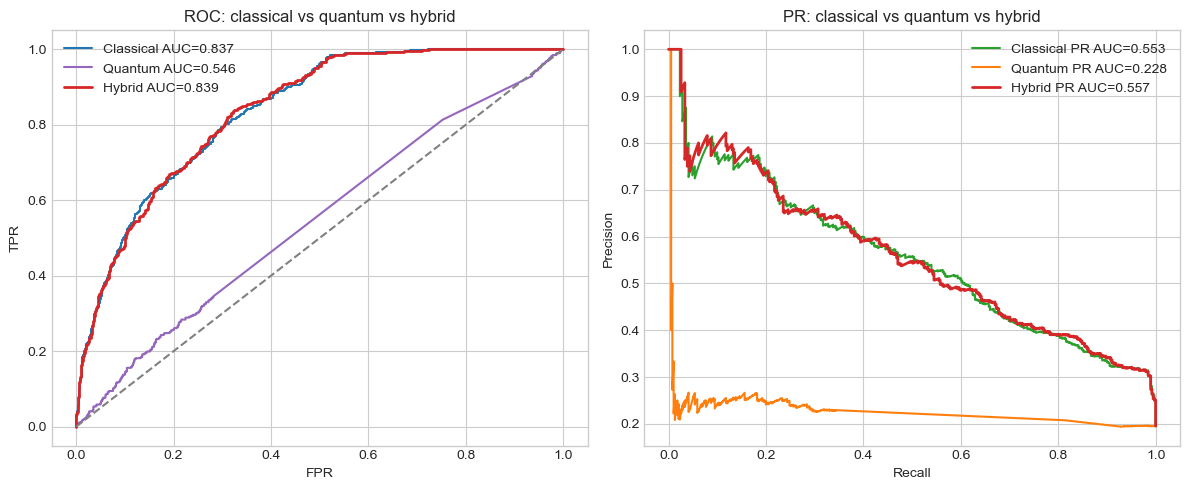

In [141]:
# ---------- 7) Plot uplift ROC/PR (stacked/hybrid vs classical/quantum) ----------
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# ROC subplot
plt.subplot(1,2,1)
# classical
if not np.isnan(classical_roc):
    plt.plot(globals().get('curves', {}).get('fpr', [0,1]), globals().get('curves', {}).get('tpr', [0,1]),
             label=f"Classical AUC={classical_roc:.3f}", color="tab:blue")
# quantum
if not np.isnan(quantum_roc):
    plt.plot(globals().get('q_curves', {}).get('fpr', [0,1]), globals().get('q_curves', {}).get('tpr', [0,1]),
             label=f"Quantum AUC={quantum_roc:.3f}", color="tab:purple")
# hybrid
plt.plot(fpr_h, tpr_h, label=f"Hybrid AUC={roc_auc_h:.3f}", color="tab:red", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC: classical vs quantum vs hybrid")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

# PR subplot
plt.subplot(1,2,2)
if not np.isnan(classical_pr):
    plt.plot(globals().get('curves', {}).get('recall', []), globals().get('curves', {}).get('precision', []),
             label=f"Classical PR AUC={classical_pr:.3f}", color="tab:green")
if not np.isnan(quantum_pr):
    plt.plot(globals().get('q_curves', {}).get('recall', []), globals().get('q_curves', {}).get('precision', []),
             label=f"Quantum PR AUC={quantum_pr:.3f}", color="tab:orange")
plt.plot(recall_h, precision_h, label=f"Hybrid PR AUC={pr_auc_h:.3f}", color="tab:red", linewidth=2)
plt.title("PR: classical vs quantum vs hybrid")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

plt.tight_layout()
plt.show()